<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_Week4_Pet_Adoption_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFO 371: Data Mining Applications

## Week 4: Pet Adoption Decision Tree
### Prof. Charles Dorner, EdD (Candidate)
### College of Computing and Informatics, Drexel University

# Import packages

In [1]:
# Pet‑Adoption demo – 35 shelter visitors -----------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt, math
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score


# Error Rate, Entropy, Gini Index
Measuring the uncertainty of an event with a probability

In [2]:
np.random.seed(22)
N = 35
pet = pd.DataFrame({
    "age_band"   : np.random.choice(["child","teen","adult","senior"], N,
                                    p=[.10,.15,.55,.20]),
    "prefers_cat": np.random.choice(["yes","no"], N, p=[.4,.6]),
    "visits_wday": np.random.choice(["weekday","weekend"], N, p=[.7,.3]),
})
# adoption rule (non‑linear on purpose)
pet["adopt"] = np.where(
        ((pet.age_band=="adult") & (pet.prefers_cat=="no")) |
        ((pet.age_band=="teen") & (pet.visits_wday=="weekend")),
    "yes", "no"
)
print(pet.head())


  age_band prefers_cat visits_wday adopt
0     teen          no     weekday    no
1    adult          no     weekend   yes
2    adult         yes     weekend    no
3   senior          no     weekday    no
4     teen          no     weekday    no


In [3]:

# --- entropy‑based info‑gain per feature ------------------------------
def H(s): c=s.value_counts(); p=c/c.sum(); return -(p*np.log2(p)).sum()
base = H(pet["adopt"])
for col in ["age_band","prefers_cat","visits_wday"]:
    w = sum(len(g)/N * H(g["adopt"]) for _,g in pet.groupby(col))
    print(f"Gain({col:<11}) = {base - w:.3f} bits")


Gain(age_band   ) = 0.261 bits
Gain(prefers_cat) = 0.282 bits
Gain(visits_wday) = 0.042 bits


In [ ]:
# 2. Entropy / Gini information‑gain for each attribute
def entropy(series):
    counts = series.value_counts()
    probs  = counts / counts.sum()
    return -(probs*np.log2(probs)).sum()

base_H = entropy(df["default"])
print(f"\nBase entropy = {base_H:.3f} bits")

def gain(col):
    weighted_H = 0
    for _, subset in df.groupby(col):
        weighted_H += len(subset)/len(df) * entropy(subset["default"])
    return base_H - weighted_H

for col in ["credit_hist","income_lvl","student"]:
    print(f"Gain({col:<11}) = {gain(col):.3f} bits")



Base entropy = 0.954 bits
Gain(credit_hist) = 0.320 bits
Gain(income_lvl ) = 0.720 bits
Gain(student    ) = 0.040 bits



Accuracy: 0.971

Rules:
 |--- prefers_cat_yes <= 0.50
|   |--- age_band_adult <= 0.50
|   |   |--- visits_wday_weekend <= 0.50
|   |   |   |--- class: no
|   |   |--- visits_wday_weekend >  0.50
|   |   |   |--- class: no
|   |--- age_band_adult >  0.50
|   |   |--- class: yes
|--- prefers_cat_yes >  0.50
|   |--- age_band_teen <= 0.50
|   |   |--- class: no
|   |--- age_band_teen >  0.50
|   |   |--- visits_wday_weekend <= 0.50
|   |   |   |--- class: no
|   |   |--- visits_wday_weekend >  0.50
|   |   |   |--- class: yes



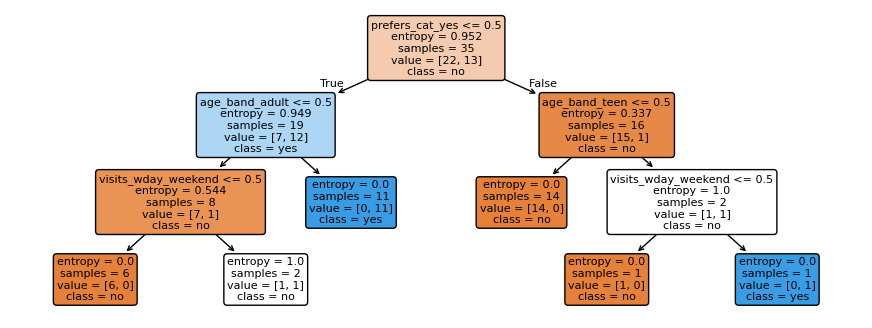

In [4]:
# --- one‑hot DT --------------------------------------------------------
pipe = Pipeline([
    ("ohe",  OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ("tree", DecisionTreeClassifier(max_depth=3, criterion="entropy", random_state=0))
]).fit(pet[["age_band","prefers_cat","visits_wday"]], pet["adopt"])

print("\nAccuracy:", round(accuracy_score(pet["adopt"],
                                          pipe.predict(pet[["age_band","prefers_cat","visits_wday"]])),3))

print("\nRules:\n",
      export_text(pipe.named_steps["tree"],
                  feature_names=pipe.named_steps["ohe"].get_feature_names_out()))

plt.figure(figsize=(11,4))
plot_tree(pipe.named_steps["tree"],
          feature_names=pipe.named_steps["ohe"].get_feature_names_out(),
          class_names=["no","yes"],
          filled=True, rounded=True, fontsize=8)
plt.show()
